# **NLP Techniques for Text Classification: Spam or Ham?**

## Introduction
Recurrent Neural Networks (RNNs) and Long Short-Term Memory (LSTM) networks are powerful tools for tackling various text-based data science challenges. These models excel at handling sequential information due to their ability to maintain context across time steps, making them well-suited for tasks like text classification, sentiment analysis, and language modeling.

While RNNs employ a simple yet effective architecture to capture temporal dependencies, LSTMs enhance this capability by mitigating the vanishing gradient problem through their complex cell structure, allowing them to learn long-term dependencies more effectively.

In this notebook, we will develop and compare the performance of RNN and LSTM models for classifying emails as spam or legitimate (ham).

## About the Data
The data was obtained from Kaggle [https://www.kaggle.com/datasets/prishasawhney/email-classification-ham-spam], containing two columns:

* **Email**: This column contains the textual description of the email/ message, offering a diverse range of vocabulary and language patterns.
* **Label**: Each review is classified into either Ham (non-spam) or Spam.

The dataset is split into three: *Train Set* consisting of 116 data points, *Validation Set* consisting of 36 data points, and *Test Set* consisting of 27 data points, totalling 179 data points. 

## **Methodology**

![methodology](methodology.png)

## **Execution**

### Imports

In [25]:
# Import Libraries
import tensorflow as tf
from keras import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, LSTM, Dropout
from keras.preprocessing import sequence
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

### Data Loading and Preprocessing

In [2]:
# Load and Process Data
file_path = 'email_classification.csv'
df = pd.read_csv(file_path)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
inputs, labels = df.email, df.label

tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(inputs)
inputs = tokenizer.texts_to_sequences(inputs)
labels = np.array([(i=='spam')+0 for i in labels])

max_features = 10000
maxlen = 20
inputs = sequence.pad_sequences(inputs, maxlen=maxlen)

test_size = round(len(labels) * 0.15)
val_size = round(len(labels) * 0.2)
train_size = len(labels) - test_size - val_size

x_train, y_train = inputs[:train_size], labels[:train_size]
x_val, y_val = inputs[train_size:train_size + val_size], labels[train_size:train_size + val_size]
x_test, y_test = inputs[train_size + val_size:], labels[train_size + val_size:]

In [3]:
print(f'train_size: {train_size}')
print(f'val_size: {val_size}')
print(f'test_size: {test_size}')

train_size: 116
val_size: 36
test_size: 27


### Exploratory Data Analysis

In [58]:
print(df.label[0] + ': ' + df.email[0])
print(df.label[1] + ': ' + df.email[1])
print(df.label[11] + ': ' + df.email[11])

spam: Act now! Limited-time offer on luxury watches. Click here to buy now!
spam: You're a winner! Click here to claim your exclusive prize.
ham: We value your feedback. Share your thoughts with us.


In [61]:
print("Input data after preprocessing:")
print(inputs[[0, 1, 11]])

Input data after preprocessing:
[[  0   0   0   0   0   0   0  85  10  48  38  32  18  56 176   5   4   2
  177  10]
 [  0   0   0   0   0   0   0   0   0   0  33   7  49   5   4   2  15   1
   34  21]
 [  0   0   0   0   0   0   0   0   0   0   0  41 189   1  61  90   1 291
   17  22]]


Ham:  100
Spam:      79


<Axes: >

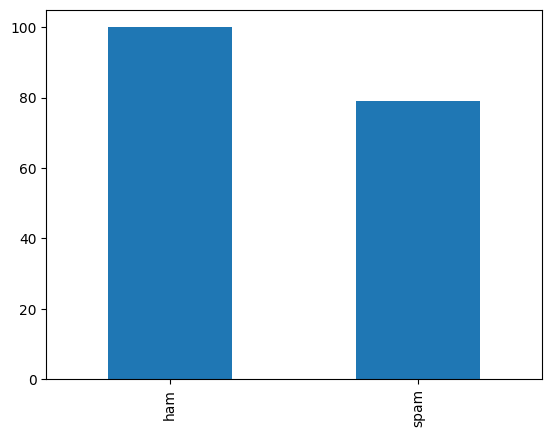

In [4]:
print(f"Ham:  {df.label.value_counts()[0]}")
print(f"Spam:      {df.label.value_counts()[1]}")
df.label.value_counts().plot.bar()

### Proportional Chance Criterion

In [5]:
PCC = sum((df.label.value_counts() / len(df))**2)
print(f"Proportion Chance Criterion = {PCC*100:.1f}%")
print(f"1.25*Proportion Chance Criterion = {PCC*125:.1f}%")

Proportion Chance Criterion = 50.7%
1.25*Proportion Chance Criterion = 63.4%


### Base Models

In [6]:
# Simple RNN Model
model_rnn = Sequential()
model_rnn.add(Embedding(max_features, 32))
model_rnn.add(SimpleRNN(32))
model_rnn.add(Dense(1, activation='sigmoid'))
model_rnn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# LSTM Model
model_lstm = Sequential()
model_lstm.add(Embedding(max_features, 32))
model_lstm.add(LSTM(32))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

### Models w/ Dropout Parameter

In [7]:
model_rnn1 = Sequential()
model_rnn1.add(Embedding(max_features, 32))
model_rnn1.add(SimpleRNN(32, dropout=0.3))  # Add dropout to RNN layer
model_rnn1.add(Dense(1, activation='sigmoid'))
model_rnn1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

model_lstm1 = Sequential()
model_lstm1.add(Embedding(max_features, 32))
model_lstm1.add(LSTM(32, dropout=0.1, recurrent_dropout=0.3))  # Add dropout to LSTM layer
model_lstm1.add(Dense(1, activation='sigmoid'))
model_lstm1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

### Training

In [8]:
rnn_checkpoint = ModelCheckpoint(
    'best_models/rnn.keras',      
    monitor='val_loss',
    save_best_only=True
)

rnn1_checkpoint = ModelCheckpoint(
    'best_models/rnn1.keras',      
    monitor='val_loss',
    save_best_only=True,
)

lstm_checkpoint = ModelCheckpoint(
    'best_models/lstm.keras',      
    monitor='val_loss',
    save_best_only=True
)

lstm1_checkpoint = ModelCheckpoint(
    'best_models/lstm1.keras',      
    monitor='val_loss',
    save_best_only=True,
)

In [9]:
history_rnn = model_rnn.fit(
    x_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[rnn_checkpoint],
    verbose=1
)

history_rnn1 = model_rnn1.fit(
    x_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[rnn1_checkpoint],
    verbose=0
)

history_lstm = model_lstm.fit(
    x_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[lstm_checkpoint],
    verbose=0
)

history_lstm1 = model_lstm1.fit(
    x_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[lstm1_checkpoint],
    verbose=0
)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - acc: 0.5362 - loss: 0.6805 - val_acc: 0.8889 - val_loss: 0.5678
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - acc: 0.9287 - loss: 0.5188 - val_acc: 0.9444 - val_loss: 0.4773
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - acc: 0.9630 - loss: 0.3726 - val_acc: 0.9722 - val_loss: 0.3806
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - acc: 0.9709 - loss: 0.2558 - val_acc: 0.9722 - val_loss: 0.3095
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - acc: 1.0000 - loss: 0.1866 - val_acc: 0.9722 - val_loss: 0.2569
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 1.0000 - loss: 0.1172 - val_acc: 0.9444 - val_loss: 0.2974
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 1.0000 - loss: 0.0866 - val_acc: 0.8611 - val_loss: 0.2981
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - acc: 1.0000 - loss: 0.0727 - val_acc: 0.9722 - val_loss: 0.1665
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - acc: 1.0000 - loss: 0.0498 -

### Evaluation

In [13]:
model_rnn = tf.keras.models.load_model("best_models/rnn.keras")
model_rnn1 = tf.keras.models.load_model("best_models/rnn1.keras")
model_lstm = tf.keras.models.load_model("best_models/lstm.keras")
model_lstm1 = tf.keras.models.load_model("best_models/lstm1.keras")

In [62]:
pred_rnn = [round(i[0]) for i in model_rnn.predict(x_test)]
pred_rnn1 = [round(i[0]) for i in model_rnn1.predict(x_test)]
pred_lstm = [round(i[0]) for i in model_lstm.predict(x_test)]
pred_lstm1 = [round(i[0]) for i in model_lstm1.predict(x_test)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


In [65]:
results = {'RNN': {'Accuracy': accuracy_score(y_test, pred_rnn),
                   'Precision': precision_score(y_test, pred_rnn),
                   'Recall': recall_score(y_test, pred_rnn),
                   'F1': f1_score(y_test, pred_rnn)},
           'LSTM': {'Accuracy': accuracy_score(y_test, pred_lstm),
                   'Precision': precision_score(y_test, pred_lstm),
                   'Recall': recall_score(y_test, pred_lstm),
                   'F1': f1_score(y_test, pred_lstm)},
           'RNN w/ Dropout': {'Accuracy': accuracy_score(y_test, pred_rnn1),
                   'Precision': precision_score(y_test, pred_rnn1),
                   'Recall': recall_score(y_test, pred_rnn1),
                   'F1': f1_score(y_test, pred_rnn1)},
           'LSTM w/ Dropout': {'Accuracy': accuracy_score(y_test, pred_lstm1),
                   'Precision': precision_score(y_test, pred_lstm1),
                   'Recall': recall_score(y_test, pred_lstm1),
                   'F1': f1_score(y_test, pred_lstm1)},
           }

display(pd.DataFrame(results).T.round(3))

,Accuracy,Precision,Recall,F1
RNN,0.963,1.000,0.923,0.960
LSTM,0.963,1.000,0.923,0.960
RNN w/ Dropout,0.926,0.923,0.923,0.923
LSTM w/ Dropout,0.963,1.000,0.923,0.960
